In [1]:
import os

import pandas as pd
import seaborn as sns

from ray import init, rllib, tune, shutdown

In [2]:
from attack_simulator.agents import ATTACKERS
from attack_simulator.env import AttackSimulationEnv
from attack_simulator.graph import AttackGraph, SIZES

In [3]:
class NoAction(rllib.policy.Policy):
    def compute_actions(self, observations, *args, **kwargs):
        return [0 for _ in observations], [], {}

    def get_weights(self):
        return {}

    def set_weights(self, weights):
        pass


no_action = rllib.agents.trainer_template.build_trainer(name="NoAction", default_policy=NoAction)

In [4]:
if os.path.isdir("/var/run/secrets/kubernetes.io"):  # inside k8s pod
    args = dict(address="auto")
else:
    # listen on all interfaces inside a container for port-forwarding to work
    dashboard_host = "0.0.0.0" if os.path.exists("/.dockerenv") else "127.0.0.1"
    args = dict(num_cpus=4, dashboard_host=dashboard_host)

# ALTERNATIVE: use the "Ray client" to connect to a remote cluster
# Unfortunately, JupyterNotebookReporter displays an object reference
# <IPython.core.display.HTML object> instead of content...
# --- --- ---
#
# from ray.util.client import worker
#
# worker.INITIAL_TIMEOUT_SEC = worker.MAX_TIMEOUT_SEC = 1
#
# ray_client_server = 'host.docker.internal' if os.path.exists("/.dockerenv") else '127.0.0.1'
# try:
#     init(address=f'ray://{ray_client_server}:10001')
# except Connection Error:
#     pass  # TODO: try something else...

In [5]:
num_episodes = 5  # run 5 episodes on the same environment
attackers = list(ATTACKERS)
graphs = [AttackGraph(dict(graph_size=size)) for size in SIZES]

config = dict(
    framework="torch",
    env=AttackSimulationEnv,
    env_config=dict(attack_graph=tune.grid_search(graphs), attacker=tune.grid_search(attackers)),
    seed=tune.grid_search([0, 1, 2, 3, 6, 7, 11, 28, 42, 1337]),
    # evaluation ONLY: avoid MultiGPU optimizer, set all relevant sizes to 0
    simple_optimizer=True,
    num_workers=0,
    train_batch_size=0,
    rollout_fragment_length=0,
    timesteps_per_iteration=0,
    # define evaluation settings
    evaluation_interval=1,
    evaluation_num_workers=1,
    evaluation_config=dict(explore=False),
    evaluation_num_episodes=num_episodes,
)

AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)
AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)
AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)
AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)
AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)
AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)
AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)


In [6]:
rename = {
    "config.env_config.attacker": "Attacker",
    "config.env_config.attack_graph": "graph",
    "evaluation.hist_stats.episode_reward": "returns",
    "evaluation.hist_stats.episode_lengths": "lengths",
}


def postprocess(results_df):
    df = results_df[rename.keys()].rename(columns=rename)
    df.dropna(inplace=True)  # remove `NaN` results from failed trials
    df["Graph size"] = df["graph"].apply(lambda g: g.num_attacks)
    del df["graph"]
    df["tuple"] = df.apply(lambda t: list(zip(t.returns, t.lengths)), axis="columns")
    del df["returns"]
    del df["lengths"]
    df = df.explode("tuple", ignore_index=True)
    df[["Returns", "Episode lengths"]] = df["tuple"].tolist()
    del df["tuple"]
    return df

In [7]:
def generate(savename):
    init(**args)
    results = tune.run(
        no_action,
        config=config,
        stop=dict(training_iteration=0),
        max_failures=3,
        queue_trials=True,
        raise_on_failed_trial=False,
        progress_reporter=tune.JupyterNotebookReporter(overwrite=True),
    )
    shutdown()
    df = postprocess(results.results_df)
    df.to_csv(savename)
    return df

In [8]:
savename = "length-tune-eval.csv"

df = generate(savename) if not os.path.exists(savename) else pd.read_csv(savename, index_col=0)

Trial name,status,loc,env_config/attack_graph,env_config/attacker,seed,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
NoAction_AttackSimulationEnv_671fc_00000,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",well-informed,0,1,0.412525,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00001,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",well-informed,0,1,1.68308,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00002,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",well-informed,0,1,3.10351,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00003,TERMINATED,,"AttackGraph(en2720.yaml[medium], 13 services, 56 attack steps)",well-informed,0,1,2.34194,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00004,TERMINATED,,"AttackGraph(en2720.yaml[large], 16 services, 62 attack steps)",well-informed,0,1,2.72094,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00005,TERMINATED,,"AttackGraph(en2720.yaml[extra-large], 16 services, 65 attack steps)",well-informed,0,1,3.88837,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00006,TERMINATED,,"AttackGraph(en2720.yaml[full], 18 services, 78 attack steps)",well-informed,0,1,9.31285,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00007,TERMINATED,,"AttackGraph(en2720.yaml[tiny], 2 services, 7 attack steps)",informed,0,1,0.378744,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00008,TERMINATED,,"AttackGraph(en2720.yaml[small], 5 services, 27 attack steps)",informed,0,1,1.34715,0,nan,nan,nan,nan
NoAction_AttackSimulationEnv_671fc_00009,TERMINATED,,"AttackGraph(en2720.yaml[medium-small], 9 services, 44 attack steps)",informed,0,1,4.23409,0,nan,nan,nan,nan


2021-10-10 16:31:55,222	INFO tune.py:561 -- Total run time: 506.13 seconds (505.08 seconds for the tuning loop).


In [9]:
sns.set(style="darkgrid", rc={"figure.figsize": (12, 8)})

Text(0.5, 1.0, 'Defender: no-action')

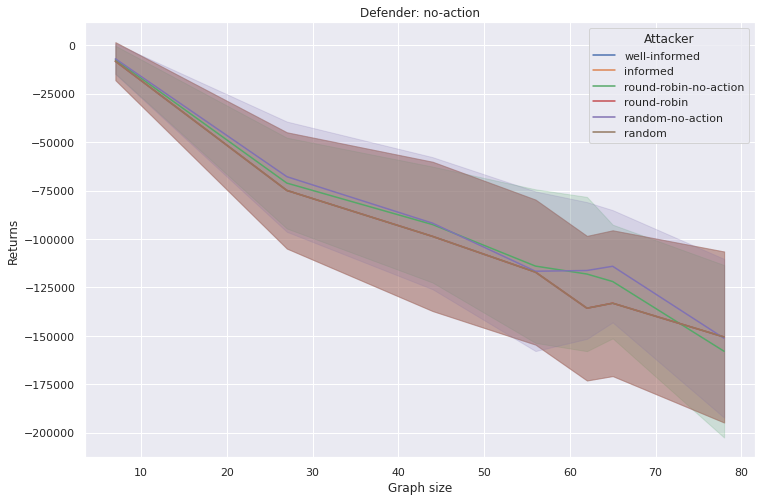

In [10]:
g = sns.lineplot(data=df, x="Graph size", y="Returns", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper right")
g.set_title("Defender: no-action")

Text(0.5, 1.0, 'Defender: no-action')

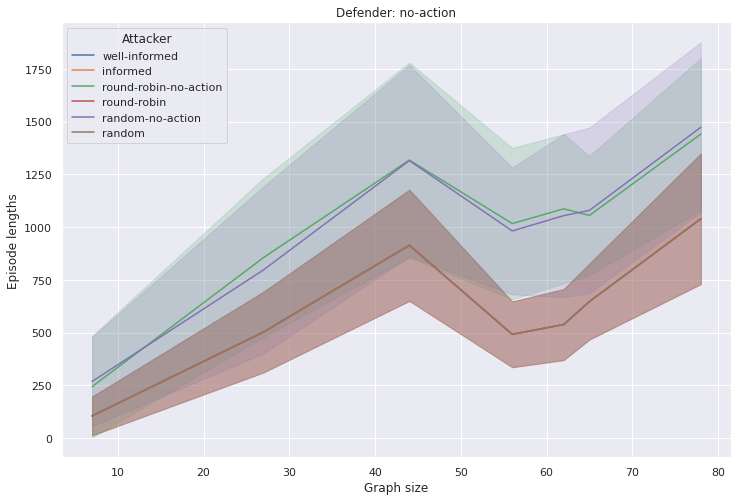

In [11]:
g = sns.lineplot(data=df, x="Graph size", y="Episode lengths", hue="Attacker", ci="sd")
g.legend(title="Attacker", loc="upper left")
g.set_title("Defender: no-action")

In [12]:
pd.set_option("display.max_columns", 32)
df.groupby("Attacker").describe()

Graph size                                              \
                           count       mean       std  min   25%   50%   75%   
Attacker                                                                       
informed                   350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   
random                     350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   
random-no-action           350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   
round-robin                350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   
round-robin-no-action      350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   
well-informed              350.0  48.428571  22.66523  7.0  27.0  56.0  65.0   

                            Returns                                         \
                        max   count           mean           std       min   
Attacker                                                                     
informed               78.0   350.0 -102644.711429  57027.668422 -263377.0   
random                 78.0   350.0 -102644.711429  57027.668422 -263377.0   
random-no-action       78.0   350.0  -95006.842857  53918.352793 -253564.0   
round-robin            78.0   350.0 -102644.711429  57027.668422 -263377.0   
round-robin-no-action  78.0   350.0  -97617.602857  55010.156061 -287718.0   
well-informed          78.0   350.0 -102644.711429  57027.668422 -263377.0   

                                                            Episode lengths  \
                             25%       50%       75%    max           count   
Attacker                                                                      
informed              -140922.25 -107557.0 -66767.50  -30.0           350.0   
random                -140922.25 -107557.0 -66767.50  -30.0           350.0   
random-no-action      -130414.00  -96607.0 -59712.25  672.0           350.0   
round-robin           -140922.25 -107557.0 -66767.50  -30.0           350.0   
round-robin-no-action -134855.00  -98484.5 -65959.75  173.0           350.0   
well-informed         -140922.25 -107557.0 -66767.50  -30.0           350.0   

                                                                               \
                              mean         std   min     25%     50%      75%   
Attacker                                                                        
informed                605.268571  349.661682  10.0  386.50   572.0   805.50   
random                  605.268571  349.661682  10.0  386.50   572.0   805.50   
random-no-action        995.514286  515.299805  26.0  664.75   937.0  1282.75   
round-robin             605.268571  349.661682  10.0  386.50   572.0   805.50   
round-robin-no-action  1002.274286  501.914363  27.0  683.75  1012.5  1286.00   
well-informed           605.268571  349.661682  10.0  386.50   572.0   805.50   

                               
                          max  
Attacker                       
informed               1634.0  
random                 1634.0  
random-no-action       2631.0  
round-robin            1634.0  
round-robin-no-action  2461.0  
well-informed          1634.0